# Blackjack: Monte Carlo

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v0')

eos = env.observation_space
eas = env.action_space

print(eos, ' : ', eos.sample(), eos.sample(), end='\n')
print(eas, ' : ', eas.n, ' : ', eas.sample())

Tuple(Discrete(32), Discrete(11), Discrete(2))  :  (16, 10, 0) (11, 2, 0)
Discrete(2)  :  2  :  0


In [3]:
for idx in range(3):
    state = env.reset() # resets so that all tuples are rational
    while True:
        print('State: {}'.format(state))
        action = eas.sample()
        state, reward, done, info = env.step(action)
        if done:
            result = 'Won :-)' if reward > 0 else "Lost :-("
            print('{}: Reward: {}'.format(result, reward))
            break
    print()

State: (15, 3, False)
Lost :-(: Reward: -1.0

State: (12, 1, False)
Lost :-(: Reward: -1.0

State: (18, 10, False)
Lost :-(: Reward: -1



# Part 1: MC Prediction

In [4]:
def generate_episode_from_limit_stochastic(env):
    episode = list()
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # 0->Stick and 1->Hit
        action = np.random.choice(np.arange(env.action_space.n), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [5]:
generate_episode_from_limit_stochastic(env)

[((13, 7, False), 0, 1.0)]

In [6]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(eas.n))
    N = defaultdict(lambda: np.zeros(eas.n))
    Q = defaultdict(lambda: np.zeros(eas.n))
    
    for idx in range(num_episodes):
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = [gamma**i for i in range(len(rewards)+1)]
        discounts = np.array(discounts)
        for i, state in enumerate(states):
            action = actions[i]
            Gt = rewards[i:] * discounts[:-(i+1)]
            
            returns_sum[state][action] += sum(Gt)
            N[state][action] += 1.0
            Q[state][action] = returns_sum[state][action] / N[state][action]
        if (idx+1) % 1000 == 0:
            print('\r Episode {}/{}'.format(idx+1, num_episodes), end='')
            sys.stdout.flush()
    return Q

mc_prediction_q(env, 2, generate_episode_from_limit_stochastic, 1)

defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>()>,
            {(8, 9, False): array([ 0., -1.]),
             (10, 9, False): array([ 0., -1.]),
             (16, 9, False): array([ 0., -1.]),
             (17, 9, False): array([ 0., -1.]),
             (18, 9, False): array([ 0., -1.]),
             (8, 6, False): array([ 0., -1.]),
             (13, 6, False): array([ 0., -1.])})

In [7]:
Q = mc_prediction_q(env, 500*1000, generate_episode_from_limit_stochastic)

 Episode 500000/500000

In [8]:
for i in range(5):
    print(Q.popitem())

((13, 7, True), array([-0.64556962, -0.08943089]))
((4, 8, False), array([-0.33333333, -0.36206897]))
((12, 3, True), array([-0.34782609, -0.09580838]))
((18, 7, True), array([ 0.43548387, -0.29187396]))
((12, 2, True), array([-0.18918919, -0.14285714]))


In [9]:
V = dict()
for k,v in Q.items():
    probs = [0.8, 0.2] if k[0] > 18 else [0.2, 0.8]
    V[k] = np.dot(v, probs)
    
for i in range(5):
    print(V.popitem())

((14, 5, True), -0.2012004801920768)
((4, 5, False), -0.27778768956289024)
((12, 8, True), -0.2250408548082967)
((4, 9, False), -0.3536231884057971)
((13, 6, True), -0.08500937979648684)


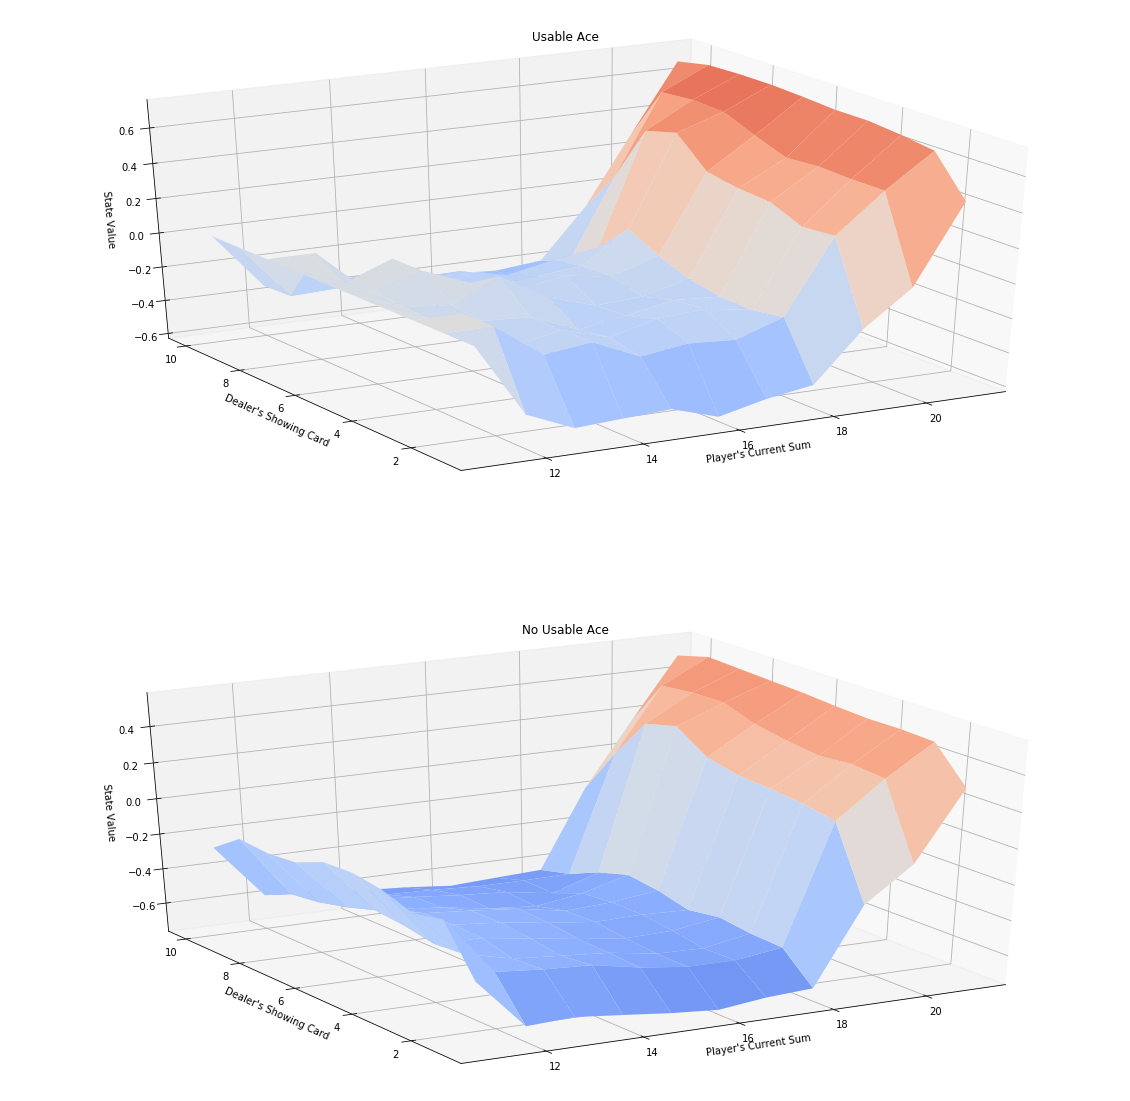

In [10]:
plot_blackjack_values(V)

# Part 2: MC Control

In [11]:
# obtains the action probabilities corresponding to epsilon-greedy policy
def get_probs(Q_s, epsilon, nA):
    best_a = np.argmax(Q_s)
    
    policy_s = np.ones(nA) * epsilon / nA
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [12]:
# generates an episode from following the epsilon-greedy policy
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = list()
    state = env.reset()
    
    while True:
        if state in Q:
            Q_s = Q[state]
            ps = get_probs(Q_s, epsilon, nA)
        else:
            ps = None
        action = np.random.choice(np.arange(nA), p=ps)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [13]:
# updates the action-value function estimate using the most recent episode
def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = [gamma**i for i in range(len(rewards)+1)]
    discounts = np.array(discounts)
    
    for i, state in enumerate(states):        
        Gt = rewards[i:] * discounts[:-(i+1)]
        Gt = sum(Gt)
        
        action = actions[i]
        diff = Gt - Q[state][action]

        Q[state][action] += alpha * diff
    return Q

In [16]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, decay=0.9999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    
    epsilon = eps_start
    
    for i in range(num_episodes):
        epsilon = max(epsilon * decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
        
        if (i+1) % 1000 == 0:
            print('\r Episode {}/{}'.format(i+1, num_episodes), end='')
            sys.stdout.flush()
    
    policy = dict()
    for k, v in Q.items():
        policy[k] = np.argmax(v)
    return policy, Q

In [17]:
policy, Q = mc_control(env, num_episodes=500000, alpha=0.02)

 Episode 500000/500000

In [18]:
# State Value Function
V = dict()
for k, v in Q.items():
    V[k] = np.max(v)

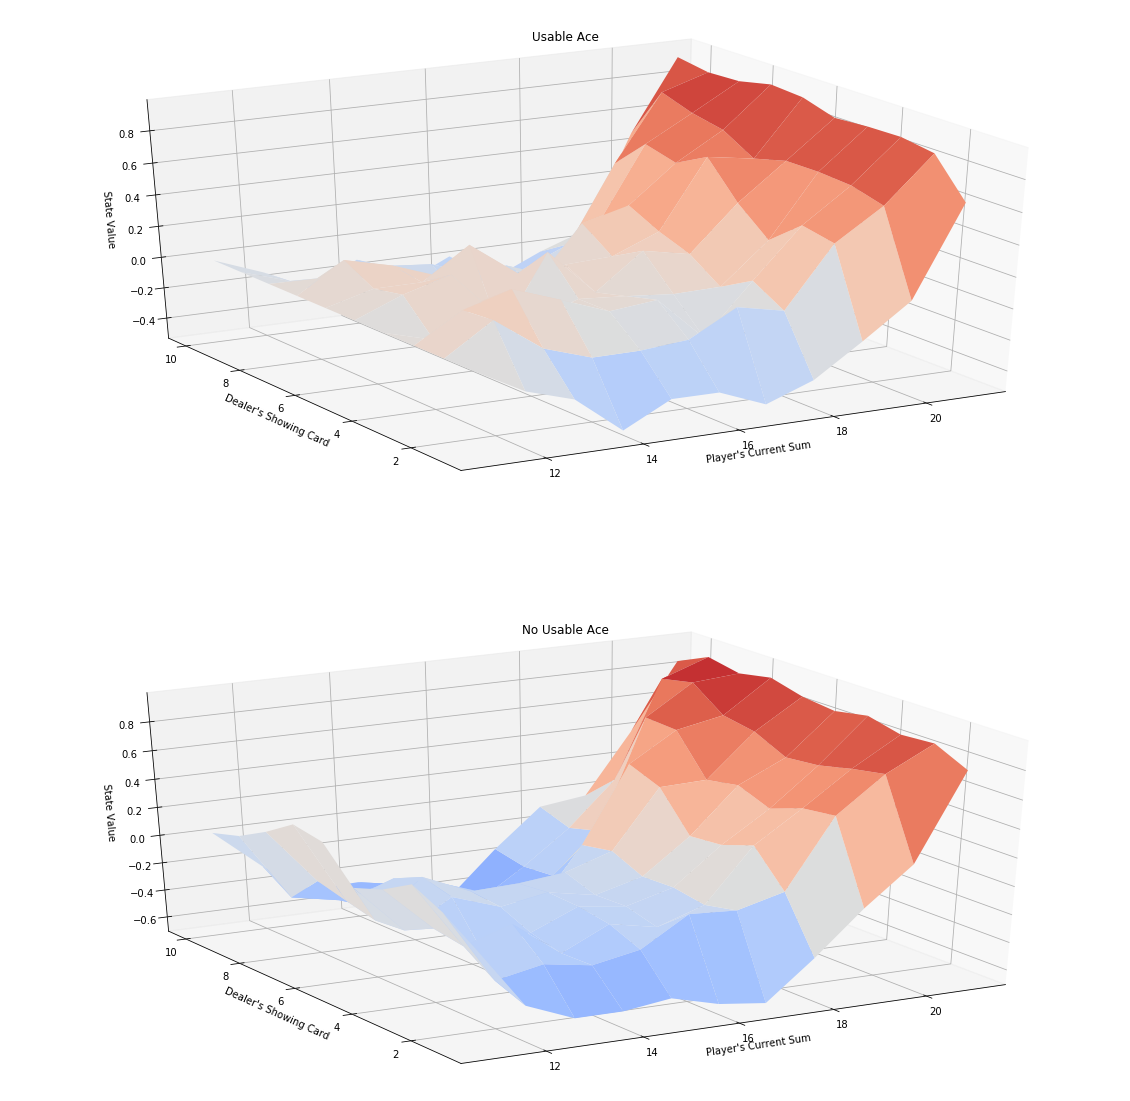

In [19]:
plot_blackjack_values(V)

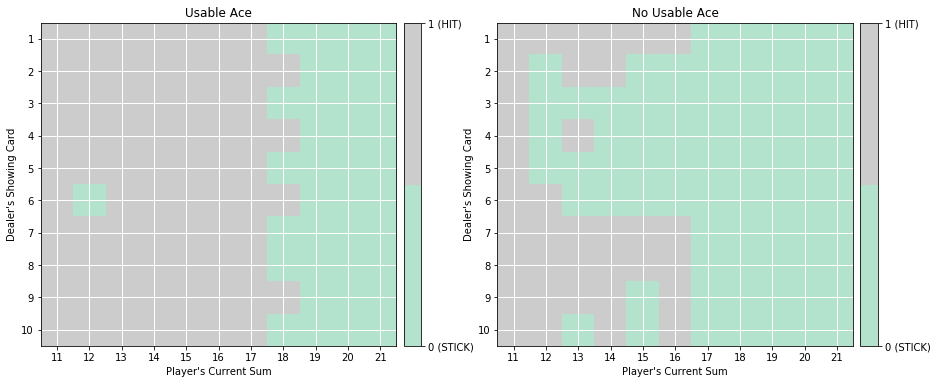

In [20]:
plot_policy(policy)